# Imitation Learning notebook - Inverse Reinforcement Learning - Use rewards from sliced RL to imitate expert behavioural movements 

In [1]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import matplotlib.pyplot as plt
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle

import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from Code.utils import Net, Memory, Agent
from Code.sliced_wasserstein_rewards import *
from Code.plotting import preprocess_states, animate
from Code.helper_functions import *

### Load expert trajectories 

In [3]:
environment = 'CartPole-v0'

t1 = 'multi_diff_lengths_excl_1'
traj1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment))

t2 = 'multi_same_lengths_1_5'
traj2 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t2,environment))

t3 = 'multi_same_lengths_0_3'
traj3 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t3,environment))

t4 = 'multi_same_lengths_1'
traj4 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t4,environment))

t5 = 'simple_length_1'
traj5 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t5,environment))

t6 = 'simple_length_1_5'
traj6 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t6,environment))

t7 = 'simple_length_0_3'
traj7 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t7,environment))

### Imitation Learning

In [4]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [12]:
def main(environment, exp, simple = False, MMOT = False, wass_PWIL = False, PWIL = False):

    env = gym.make(environment)

    action_dim = env.action_space.n
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0
    
    action_list = [i for i in range(action_dim)]
    

    for i_ep in range(200):

        rewards = []
        new_states = []
        old_states = []
        action_indexes = []

        score = 0

        #We fix the departure state 
        #state = env.reset()
        #env.env.state = np.array([np.pi/2, 0.5])
        #env.env.last_u = None
        #state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
                
        state = env.reset()
        state = np.array([-6.18010447e+00, -5.22830905e+00,  7.34760972e+00,
         5.29961320e+00]) #fix the first state
        
        for t in range(200):
            action, action_index = agent.select_action(state)
            action = action_list[action_index]
            
            state_, reward, done, _ = env.step(action)
            score += reward
            old_states.append(state)

            env.render()
            #agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            action_indexes.append(action_index)
            rewards.append(reward)
            new_states.append(state_)

        states_tens = [torch.tensor(elt) for elt in old_states] #agent rollout 
        states_tens = torch.stack(states_tens).float()

        
        if MMOT is True :
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float(), torch.tensor(exp[1]).float(), torch.tensor(exp[2]).float(), torch.tensor(exp[3]).float(), torch.tensor(exp[4]).float()], num_projections = 50)
        
        elif simple is True : 
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float()], num_projections = 50)
            
        elif wass_PWIL is True : 
            pwil_exp = torch.tensor(concatenate_and_sample_cartpole(exp)).float()
            #pwil_exp = torch.tensor(concatenate_and_sample(exp)).float()
            rewards_multitask = rewarder_multi([states_tens, pwil_exp], num_projections = 50)
            
            
        for t in range(200):
            rewards[t] = torch.exp(-5*rewards_multitask[t,0])
            agent.store_transition(Transition(old_states[t], action_indexes[t], rewards[t], new_states[t]))

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )

    env.close()
    
    return training_records
    
    
    

#### Unique expert trajectory


In [17]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    training_record_simple_l_1 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.8 score of current env 22.0
Ep 1 Average score: -806.8199999999999 score of current env 12.0
Ep 2 Average score: -724.338 score of current env 18.0
Ep 3 Average score: -650.8041999999999 score of current env 11.0
Ep 4 Average score: -583.92378 score of current env 18.0
Ep 5 Average score: -522.9314019999999 score of current env 26.0
Ep 6 Average score: -466.93826179999996 score of current env 37.0
Ep 7 Average score: -415.24443562 score of current env 50.0
Ep 8 Average score: -372.619992058 score of current env 11.0
Ep 9 Average score: -333.4579928522 score of current env 19.0
Ep 10 Average score: -297.41219356698 score of current env 27.0
Ep 11 Average score: -266.17097421028205 score of current env 15.0
Ep 12 Average score: -238.45387678925385 score of current env 11.0
Ep 13 Average score: -213.10848911032846 score of current env 15.0
Ep 14 Average score: -190.09764019929563 score of current env 17.0
Ep 15 Average score: -163.58787617936608 score of current e

Ep 124 Average score: 198.53781213455946 score of current env 200.0
Ep 125 Average score: 198.68403092110353 score of current env 200.0
Ep 126 Average score: 198.81562782899317 score of current env 200.0
Ep 127 Average score: 198.93406504609385 score of current env 200.0
Ep 128 Average score: 199.04065854148448 score of current env 200.0
Ep 129 Average score: 199.13659268733602 score of current env 200.0
Ep 130 Average score: 199.22293341860242 score of current env 200.0
Ep 131 Average score: 199.30064007674218 score of current env 200.0
Ep 132 Average score: 199.37057606906797 score of current env 200.0
Ep 133 Average score: 199.43351846216117 score of current env 200.0
Ep 134 Average score: 199.49016661594507 score of current env 200.0
Ep 135 Average score: 199.54114995435057 score of current env 200.0
Ep 136 Average score: 199.58703495891552 score of current env 200.0
Ep 137 Average score: 199.62833146302398 score of current env 200.0
Ep 138 Average score: 199.6654983167216 score of

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj6
    training_record_simple_l_1_5 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -804.34 score of current env 44.0
Ep 2 Average score: -722.4060000000001 score of current env 15.0
Ep 3 Average score: -648.7654000000001 score of current env 14.0
Ep 4 Average score: -582.7888600000001 score of current env 11.0
Ep 5 Average score: -522.7099740000002 score of current env 18.0
Ep 6 Average score: -467.6389766000002 score of current env 28.0
Ep 7 Average score: -419.1750789400002 score of current env 17.0
Ep 8 Average score: -374.45757104600017 score of current env 28.0
Ep 9 Average score: -335.31181394140015 score of current env 17.0
Ep 10 Average score: -300.3806325472602 score of current env 14.0
Ep 11 Average score: -269.04256929253415 score of current env 13.0
Ep 12 Average score: -240.83831236328072 score of current env 13.0
Ep 13 Average score: -215.15448112695265 score of current env 16.0
Ep 14 Average score: -192.5390330142574 score of current env 11.0
Ep 15 Average score: -170.885129712831

Ep 124 Average score: 188.98081893470572 score of current env 200.0
Ep 125 Average score: 190.08273704123516 score of current env 200.0
Ep 126 Average score: 191.07446333711164 score of current env 200.0
Ep 127 Average score: 191.96701700340049 score of current env 200.0
Ep 128 Average score: 192.77031530306044 score of current env 200.0
Ep 129 Average score: 193.4932837727544 score of current env 200.0
Ep 130 Average score: 194.14395539547897 score of current env 200.0
Ep 131 Average score: 194.7295598559311 score of current env 200.0
Ep 132 Average score: 195.25660387033798 score of current env 200.0
Ep 133 Average score: 195.7309434833042 score of current env 200.0
Ep 134 Average score: 196.1578491349738 score of current env 200.0
Ep 135 Average score: 196.5420642214764 score of current env 200.0
Ep 136 Average score: 196.88785779932877 score of current env 200.0
Ep 137 Average score: 197.19907201939589 score of current env 200.0
Ep 138 Average score: 197.4791648174563 score of curr

In [19]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj7
    training_record_simple_l_0_3 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -806.9900000000001 score of current env 13.0
Ep 2 Average score: -723.7910000000002 score of current env 25.0
Ep 3 Average score: -649.7119000000001 score of current env 17.0
Ep 4 Average score: -583.3407100000002 score of current env 14.0
Ep 5 Average score: -522.8066390000001 score of current env 22.0
Ep 6 Average score: -466.92597510000013 score of current env 36.0
Ep 7 Average score: -417.83337759000017 score of current env 24.0
Ep 8 Average score: -374.1500398310002 score of current env 19.0
Ep 9 Average score: -334.2350358479002 score of current env 25.0
Ep 10 Average score: -297.1115322631102 score of current env 37.0
Ep 11 Average score: -266.0003790367992 score of current env 14.0
Ep 12 Average score: -238.40034113311927 score of current env 10.0
Ep 13 Average score: -213.16030701980733 score of current env 14.0
Ep 14 Average score: -182.6442763178266 score of current env 92.0
Ep 15 Average score: -160.57

Ep 124 Average score: 199.89951798861347 score of current env 200.0
Ep 125 Average score: 199.90956618975213 score of current env 200.0
Ep 126 Average score: 199.9186095707769 score of current env 200.0
Ep 127 Average score: 199.92674861369923 score of current env 200.0
Ep 128 Average score: 199.9340737523293 score of current env 200.0
Ep 129 Average score: 199.9406663770964 score of current env 200.0
Ep 130 Average score: 199.94659973938676 score of current env 200.0
Ep 131 Average score: 199.9519397654481 score of current env 200.0
Ep 132 Average score: 199.95674578890328 score of current env 200.0
Ep 133 Average score: 199.96107121001296 score of current env 200.0
Ep 134 Average score: 199.96496408901166 score of current env 200.0
Ep 135 Average score: 199.9684676801105 score of current env 200.0
Ep 136 Average score: 199.97162091209947 score of current env 200.0
Ep 137 Average score: 199.97445882088954 score of current env 200.0
Ep 138 Average score: 199.97701293880058 score of cur

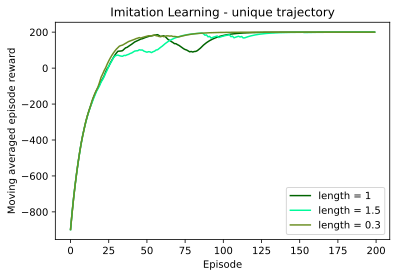

In [20]:
plt.plot([r.ep for r in training_record_simple_l_1], [r.reward for r in training_record_simple_l_1], color = 'darkgreen')
plt.plot([r.ep for r in training_record_simple_l_1_5], [r.reward for r in training_record_simple_l_1_5], color = 'mediumspringgreen')
plt.plot([r.ep for r in training_record_simple_l_0_3], [r.reward for r in training_record_simple_l_0_3], color = 'olivedrab')

plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - unique trajectory')
plt.legend(["length = 1", "length = 1.5", "length = 0.3"])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/unique_trajectory_environment_rewards_%s.png"%environment)

plt.show()


#### 5 expert trajectories of same length

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj2
    training_record_multiple_l_1_5_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -806.02 score of current env 29.0
Ep 2 Average score: -723.318 score of current env 21.0
Ep 3 Average score: -649.5862000000001 score of current env 14.0
Ep 4 Average score: -583.2275800000001 score of current env 14.0
Ep 5 Average score: -523.4048220000001 score of current env 15.0
Ep 6 Average score: -468.1643398000001 score of current env 29.0
Ep 7 Average score: -420.2479058200001 score of current env 11.0
Ep 8 Average score: -373.8231152380001 score of current env 44.0
Ep 9 Average score: -333.04080371420014 score of current env 34.0
Ep 10 Average score: -298.4367233427801 score of current env 13.0
Ep 11 Average score: -267.69305100850215 score of current env 9.0
Ep 12 Average score: -239.82374590765195 score of current env 11.0
Ep 13 Average score: -213.64137131688676 score of current env 22.0
Ep 14 Average score: -190.97723418519809 score of current env 13.0
Ep 15 Average score: -163.6795107666783 score of 

Ep 125 Average score: 123.56452298659926 score of current env 132.0
Ep 126 Average score: 123.50807068793934 score of current env 123.0
Ep 127 Average score: 125.45726361914541 score of current env 143.0
Ep 128 Average score: 132.31153725723087 score of current env 194.0
Ep 129 Average score: 139.08038353150778 score of current env 200.0
Ep 130 Average score: 141.572345178357 score of current env 164.0
Ep 131 Average score: 145.7151106605213 score of current env 183.0
Ep 132 Average score: 151.14359959446918 score of current env 200.0
Ep 133 Average score: 156.02923963502226 score of current env 200.0
Ep 134 Average score: 160.22631567152004 score of current env 198.0
Ep 135 Average score: 164.20368410436805 score of current env 200.0
Ep 136 Average score: 167.08331569393127 score of current env 193.0
Ep 137 Average score: 170.37498412453814 score of current env 200.0
Ep 138 Average score: 173.33748571208434 score of current env 200.0
Ep 139 Average score: 176.00373714087593 score of c

In [13]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj2
    training_record_multiple_l_1_5_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.1 score of current env 29.0
Ep 1 Average score: -804.79 score of current env 26.0
Ep 2 Average score: -722.9110000000001 score of current env 14.0
Ep 3 Average score: -648.3199000000001 score of current env 23.0
Ep 4 Average score: -581.38791 score of current env 21.0
Ep 5 Average score: -521.2491190000001 score of current env 20.0
Ep 6 Average score: -467.6242071000001 score of current env 15.0
Ep 7 Average score: -419.76178639000005 score of current env 11.0
Ep 8 Average score: -376.88560775100007 score of current env 9.0
Ep 9 Average score: -335.2970469759001 score of current env 39.0
Ep 10 Average score: -300.36734227831016 score of current env 14.0
Ep 11 Average score: -269.4306080504792 score of current env 9.0
Ep 12 Average score: -241.48754724543127 score of current env 10.0
Ep 13 Average score: -216.33879252088815 score of current env 10.0
Ep 14 Average score: -193.80491326879934 score of current env 9.0
Ep 15 Average score: -173.0244219419194 score of

Ep 125 Average score: 163.62960597442725 score of current env 114.0
Ep 126 Average score: 167.26664537698454 score of current env 200.0
Ep 127 Average score: 161.7399808392861 score of current env 112.0
Ep 128 Average score: 157.8659827553575 score of current env 123.0
Ep 129 Average score: 156.07938447982175 score of current env 140.0
Ep 130 Average score: 156.57144603183957 score of current env 161.0
Ep 131 Average score: 154.0143014286556 score of current env 131.0
Ep 132 Average score: 151.51287128579006 score of current env 129.0
Ep 133 Average score: 152.16158415721105 score of current env 158.0
Ep 134 Average score: 149.04542574148994 score of current env 121.0
Ep 135 Average score: 154.14088316734095 score of current env 200.0
Ep 136 Average score: 158.72679485060686 score of current env 200.0
Ep 137 Average score: 162.8541153655462 score of current env 200.0
Ep 138 Average score: 155.46870382899158 score of current env 89.0
Ep 139 Average score: 159.92183344609242 score of cur

In [15]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj3
    training_record_multiple_l_0_3_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -806.62 score of current env 23.0
Ep 2 Average score: -722.958 score of current env 30.0
Ep 3 Average score: -649.5622 score of current env 11.0
Ep 4 Average score: -581.80598 score of current env 28.0
Ep 5 Average score: -521.625382 score of current env 20.0
Ep 6 Average score: -468.16284379999996 score of current env 13.0
Ep 7 Average score: -420.2465594199999 score of current env 11.0
Ep 8 Average score: -376.22190347799994 score of current env 20.0
Ep 9 Average score: -336.49971313019995 score of current env 21.0
Ep 10 Average score: -301.24974181717994 score of current env 16.0
Ep 11 Average score: -268.52476763546196 score of current env 26.0
Ep 12 Average score: -240.57229087191578 score of current env 11.0
Ep 13 Average score: -215.4150617847242 score of current env 11.0
Ep 14 Average score: -190.7735556062518 score of current env 31.0
Ep 15 Average score: -153.49620004562664 score of current env 182.0
Ep 

Ep 125 Average score: 197.3190126358459 score of current env 200.0
Ep 126 Average score: 197.58711137226132 score of current env 200.0
Ep 127 Average score: 197.8284002350352 score of current env 200.0
Ep 128 Average score: 198.04556021153167 score of current env 200.0
Ep 129 Average score: 198.2410041903785 score of current env 200.0
Ep 130 Average score: 198.41690377134066 score of current env 200.0
Ep 131 Average score: 198.5752133942066 score of current env 200.0
Ep 132 Average score: 198.71769205478594 score of current env 200.0
Ep 133 Average score: 198.84592284930736 score of current env 200.0
Ep 134 Average score: 198.96133056437662 score of current env 200.0
Ep 135 Average score: 199.06519750793896 score of current env 200.0
Ep 136 Average score: 199.15867775714506 score of current env 200.0
Ep 137 Average score: 199.24280998143055 score of current env 200.0
Ep 138 Average score: 199.3185289832875 score of current env 200.0
Ep 139 Average score: 199.38667608495876 score of cur

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj3
    training_record_multiple_l_0_3_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -894.7 score of current env 53.0
Ep 1 Average score: -803.9300000000001 score of current env 13.0
Ep 2 Average score: -721.1370000000001 score of current env 24.0
Ep 3 Average score: -641.6233000000001 score of current env 74.0
Ep 4 Average score: -576.1609700000001 score of current env 13.0
Ep 5 Average score: -517.2448730000002 score of current env 13.0
Ep 6 Average score: -464.1203857000002 score of current env 14.0
Ep 7 Average score: -413.6083471300002 score of current env 41.0
Ep 8 Average score: -370.14751241700014 score of current env 21.0
Ep 9 Average score: -330.8327611753001 score of current env 23.0
Ep 10 Average score: -295.6494850577701 score of current env 21.0
Ep 11 Average score: -264.0845365519931 score of current env 20.0
Ep 12 Average score: -236.1760828967938 score of current env 15.0
Ep 13 Average score: -210.05847460711442 score of current env 25.0
Ep 14 Average score: -185.952627146403 score of current env 31.0
Ep 15 Average score: -161.85736

Ep 124 Average score: 197.3330191306957 score of current env 200.0
Ep 125 Average score: 197.59971721762614 score of current env 200.0
Ep 126 Average score: 197.83974549586353 score of current env 200.0
Ep 127 Average score: 198.05577094627716 score of current env 200.0
Ep 128 Average score: 198.25019385164944 score of current env 200.0
Ep 129 Average score: 198.4251744664845 score of current env 200.0
Ep 130 Average score: 198.58265701983603 score of current env 200.0
Ep 131 Average score: 198.72439131785242 score of current env 200.0
Ep 132 Average score: 198.8519521860672 score of current env 200.0
Ep 133 Average score: 198.96675696746047 score of current env 200.0
Ep 134 Average score: 199.07008127071444 score of current env 200.0
Ep 135 Average score: 199.163073143643 score of current env 200.0
Ep 136 Average score: 199.2467658292787 score of current env 200.0
Ep 137 Average score: 199.32208924635083 score of current env 200.0
Ep 138 Average score: 199.38988032171574 score of curr

In [17]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    training_record_multiple_l_1_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -806.85 score of current env 18.0
Ep 2 Average score: -722.8650000000001 score of current env 33.0
Ep 3 Average score: -647.9785 score of current env 26.0
Ep 4 Average score: -581.8806500000001 score of current env 13.0
Ep 5 Average score: -518.2925850000001 score of current env 54.0
Ep 6 Average score: -464.36332650000014 score of current env 21.0
Ep 7 Average score: -412.02699385000017 score of current env 59.0
Ep 8 Average score: -366.52429446500014 score of current env 43.0
Ep 9 Average score: -327.37186501850016 score of current env 25.0
Ep 10 Average score: -290.43467851665014 score of current env 42.0
Ep 11 Average score: -258.99121066498515 score of current env 24.0
Ep 12 Average score: -225.69208959848663 score of current env 74.0
Ep 13 Average score: -200.922880638638 score of current env 22.0
Ep 14 Average score: -176.43059257477418 score of current env 44.0
Ep 15 Average score: -154.5875333172968 score

Ep 124 Average score: 199.72296505586317 score of current env 200.0
Ep 125 Average score: 199.75066855027686 score of current env 200.0
Ep 126 Average score: 199.77560169524918 score of current env 200.0
Ep 127 Average score: 199.79804152572427 score of current env 200.0
Ep 128 Average score: 199.81823737315185 score of current env 200.0
Ep 129 Average score: 199.83641363583666 score of current env 200.0
Ep 130 Average score: 199.852772272253 score of current env 200.0
Ep 131 Average score: 199.8674950450277 score of current env 200.0
Ep 132 Average score: 199.88074554052494 score of current env 200.0
Ep 133 Average score: 199.89267098647244 score of current env 200.0
Ep 134 Average score: 199.9034038878252 score of current env 200.0
Ep 135 Average score: 199.91306349904266 score of current env 200.0
Ep 136 Average score: 199.92175714913841 score of current env 200.0
Ep 137 Average score: 199.9295814342246 score of current env 200.0
Ep 138 Average score: 199.93662329080215 score of cur

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    training_record_multiple_l_1_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -896.9 score of current env 31.0
Ep 1 Average score: -803.71 score of current env 35.0
Ep 2 Average score: -720.839 score of current env 25.0
Ep 3 Average score: -647.0551 score of current env 17.0
Ep 4 Average score: -580.24959 score of current env 21.0
Ep 5 Average score: -521.124631 score of current env 11.0
Ep 6 Average score: -466.3121679 score of current env 27.0
Ep 7 Average score: -415.98095111000003 score of current env 37.0
Ep 8 Average score: -370.382855999 score of current env 40.0
Ep 9 Average score: -332.0445703991 score of current env 13.0
Ep 10 Average score: -296.84011335919 score of current env 20.0
Ep 11 Average score: -266.056102023271 score of current env 11.0
Ep 12 Average score: -234.95049182094394 score of current env 45.0
Ep 13 Average score: -208.75544263884956 score of current env 27.0
Ep 14 Average score: -182.3798983749646 score of current env 55.0
Ep 15 Average score: -161.34190853746813 score of current env 28.0
Ep 16 Average score: -1

Ep 125 Average score: 177.262085257128 score of current env 200.0
Ep 126 Average score: 179.53587673141521 score of current env 200.0
Ep 127 Average score: 181.5822890582737 score of current env 200.0
Ep 128 Average score: 183.42406015244632 score of current env 200.0
Ep 129 Average score: 185.0816541372017 score of current env 200.0
Ep 130 Average score: 186.57348872348152 score of current env 200.0
Ep 131 Average score: 187.91613985113338 score of current env 200.0
Ep 132 Average score: 189.12452586602004 score of current env 200.0
Ep 133 Average score: 190.21207327941804 score of current env 200.0
Ep 134 Average score: 191.19086595147624 score of current env 200.0
Ep 135 Average score: 192.07177935632862 score of current env 200.0
Ep 136 Average score: 192.86460142069575 score of current env 200.0
Ep 137 Average score: 193.5781412786262 score of current env 200.0
Ep 138 Average score: 194.22032715076358 score of current env 200.0
Ep 139 Average score: 194.79829443568724 score of cur

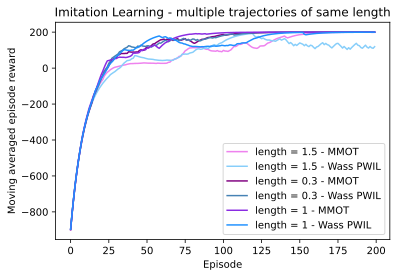

In [19]:
plt.plot([r.ep for r in training_record_multiple_l_1_5_MMOT], [r.reward for r in training_record_multiple_l_1_5_MMOT], color = 'violet')
plt.plot([r.ep for r in training_record_multiple_l_1_5_wass_PWIL], [r.reward for r in training_record_multiple_l_1_5_wass_PWIL], color = 'lightskyblue')
plt.plot([r.ep for r in training_record_multiple_l_0_3_MMOT], [r.reward for r in training_record_multiple_l_0_3_MMOT], color = 'purple')
plt.plot([r.ep for r in training_record_multiple_l_0_3_wass_PWIL], [r.reward for r in training_record_multiple_l_0_3_wass_PWIL], color = 'steelblue')
plt.plot([r.ep for r in training_record_multiple_l_1_MMOT], [r.reward for r in training_record_multiple_l_1_MMOT], color = 'blueviolet')
plt.plot([r.ep for r in training_record_multiple_l_1_wass_PWIL], [r.reward for r in training_record_multiple_l_1_wass_PWIL], color = 'dodgerblue')

plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - multiple trajectories of same length')
plt.legend(["length = 1.5 - MMOT","length = 1.5 - Wass PWIL", "length = 0.3 - MMOT", "length = 0.3 - Wass PWIL",
            "length = 1 - MMOT", "length = 1 - Wass PWIL" ])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/mult_traj_same_len_environment_rewards_%s.png"%environment)


plt.show()


#### 5 expert trajectories of different length

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    training_records_diff_len_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.33 score of current env 15.0
Ep 2 Average score: -724.897 score of current env 17.0
Ep 3 Average score: -650.7073 score of current env 17.0
Ep 4 Average score: -583.73657 score of current env 19.0
Ep 5 Average score: -522.662913 score of current env 27.0
Ep 6 Average score: -467.8966217 score of current env 25.0
Ep 7 Average score: -419.20695953000006 score of current env 19.0
Ep 8 Average score: -375.48626357700005 score of current env 18.0
Ep 9 Average score: -335.8376372193 score of current env 21.0
Ep 10 Average score: -300.25387349737 score of current env 20.0
Ep 11 Average score: -264.82848614763304 score of current env 54.0
Ep 12 Average score: -235.34563753286974 score of current env 30.0
Ep 13 Average score: -209.81107377958278 score of current env 20.0
Ep 14 Average score: -185.9299664016245 score of current env 29.0
Ep 15 Average score: -164.93696976146205 score of current env 24.0
Ep 16 Average sc

Ep 125 Average score: 197.35826265676602 score of current env 200.0
Ep 126 Average score: 197.62243639108942 score of current env 200.0
Ep 127 Average score: 197.8601927519805 score of current env 200.0
Ep 128 Average score: 198.07417347678245 score of current env 200.0
Ep 129 Average score: 198.2667561291042 score of current env 200.0
Ep 130 Average score: 198.4400805161938 score of current env 200.0
Ep 131 Average score: 198.59607246457443 score of current env 200.0
Ep 132 Average score: 198.736465218117 score of current env 200.0
Ep 133 Average score: 198.86281869630528 score of current env 200.0
Ep 134 Average score: 198.97653682667476 score of current env 200.0
Ep 135 Average score: 199.07888314400728 score of current env 200.0
Ep 136 Average score: 199.17099482960654 score of current env 200.0
Ep 137 Average score: 199.2538953466459 score of current env 200.0
Ep 138 Average score: 199.3285058119813 score of current env 200.0
Ep 139 Average score: 199.39565523078318 score of curre

In [23]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    training_records_diff_len_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -806.87 score of current env 16.0
Ep 2 Average score: -719.783 score of current env 64.0
Ep 3 Average score: -644.1047 score of current env 37.0
Ep 4 Average score: -578.29423 score of current env 14.0
Ep 5 Average score: -518.2648069999999 score of current env 22.0
Ep 6 Average score: -464.4383262999999 score of current env 20.0
Ep 7 Average score: -414.59449366999996 score of current env 34.0
Ep 8 Average score: -372.03504430299995 score of current env 11.0
Ep 9 Average score: -329.4315398727 score of current env 54.0
Ep 10 Average score: -294.88838588543 score of current env 16.0
Ep 11 Average score: -264.49954729688704 score of current env 9.0
Ep 12 Average score: -236.74959256719833 score of current env 13.0
Ep 13 Average score: -210.7746333104785 score of current env 23.0
Ep 14 Average score: -188.09716997943065 score of current env 16.0
Ep 15 Average score: -164.78745298148758 score of current env 45.0
Ep 1

Ep 126 Average score: 101.25691541243553 score of current env 84.0
Ep 127 Average score: 104.73122387119199 score of current env 136.0
Ep 128 Average score: 105.2581014840728 score of current env 110.0
Ep 129 Average score: 105.03229133566552 score of current env 103.0
Ep 130 Average score: 108.02906220209897 score of current env 135.0
Ep 131 Average score: 108.22615598188908 score of current env 110.0
Ep 132 Average score: 117.40354038370018 score of current env 200.0
Ep 133 Average score: 125.66318634533016 score of current env 200.0
Ep 134 Average score: 124.79686771079714 score of current env 117.0
Ep 135 Average score: 124.21718093971744 score of current env 119.0
Ep 136 Average score: 123.3954628457457 score of current env 116.0
Ep 137 Average score: 123.25591656117113 score of current env 122.0
Ep 138 Average score: 123.13032490505402 score of current env 122.0
Ep 139 Average score: 122.91729241454863 score of current env 121.0
Ep 140 Average score: 129.92556317309376 score of c

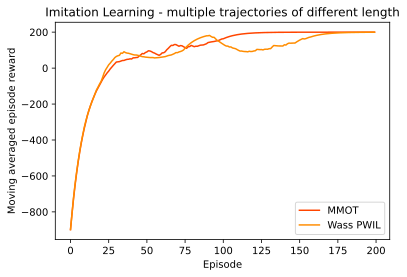

In [25]:
plt.plot([r.ep for r in training_records_diff_len_MMOT], [r.reward for r in training_records_diff_len_MMOT], color = 'orangered')
plt.plot([r.ep for r in training_records_diff_len_wass_PWIL], [r.reward for r in training_records_diff_len_wass_PWIL], color = 'darkorange')
    
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - multiple trajectories of different length')
plt.legend(['MMOT', 'Wass PWIL'])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/mult_traj_mult_len_environment_rewards_%s.png"%environment)

plt.show()